In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importing required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
infosys_stock_data = pd.read_csv('stockdatainfosys.csv')
infosys_stock_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,29-01-2015,533.799988,537.337524,532.062500,535.724976,447.274323,632020
1,30-01-2015,538.000000,540.900024,531.599976,535.687500,447.243011,967412
2,02-02-2015,535.000000,537.799988,531.912476,533.587524,445.489777,257932
3,03-02-2015,535.000000,535.000000,525.762512,530.087524,442.567749,294284
4,04-02-2015,532.000000,537.375000,532.000000,535.512512,447.096924,218144


In [4]:
infosys_stock_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1728 non-null   object 
 1   Open       1728 non-null   float64
 2   High       1728 non-null   float64
 3   Low        1728 non-null   float64
 4   Close      1728 non-null   float64
 5   Adj Close  1728 non-null   float64
 6   Volume     1728 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 94.6+ KB


In [5]:
infosys_stock_data = infosys_stock_data[['Date','Open','Close']] # Extracting required columns
infosys_stock_data['Date'] = pd.to_datetime(infosys_stock_data['Date'].apply(lambda x: x.split()[0])) # Selecting only date
infosys_stock_data.set_index('Date',drop=True,inplace=True) # Setting date column as index
infosys_stock_data.head()

,Open,Close
Date,,
2015-01-29,533.799988,535.724976
2015-01-30,538.000000,535.687500
2015-02-02,535.000000,533.587524
2015-03-02,535.000000,530.087524
2015-04-02,532.000000,535.512512


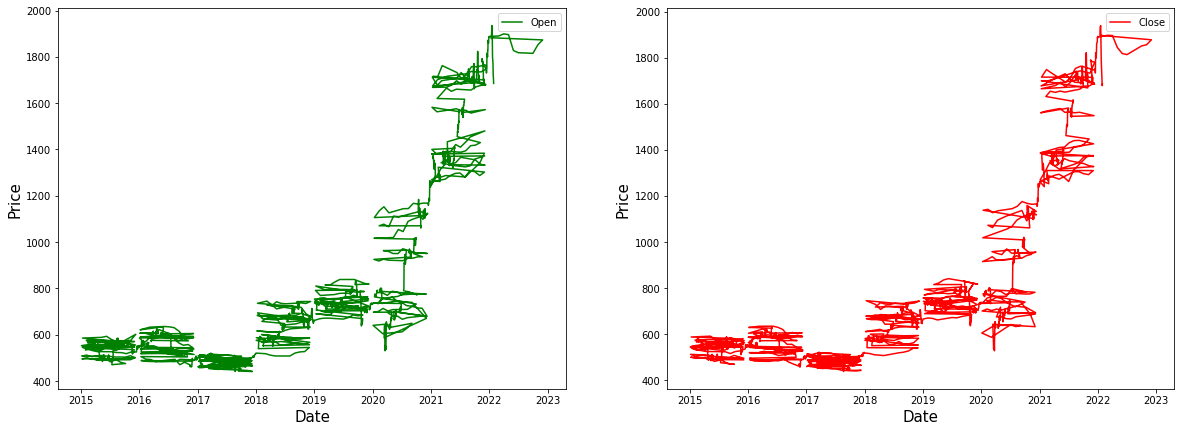

In [6]:
fg, ax =plt.subplots(1,2,figsize=(20,7))
ax[0].plot(infosys_stock_data['Open'],label='Open',color='green')
ax[0].set_xlabel('Date',size=15)
ax[0].set_ylabel('Price',size=15)
ax[0].legend()

ax[1].plot(infosys_stock_data['Close'],label='Close',color='red')
ax[1].set_xlabel('Date',size=15)
ax[1].set_ylabel('Price',size=15)
ax[1].legend()

fg.show()

# Data Pre-Processing

In [7]:
from sklearn.preprocessing import MinMaxScaler
MMS = MinMaxScaler()
infosys_stock_data[infosys_stock_data.columns] = MMS.fit_transform(infosys_stock_data)

In [8]:
infosys_stock_data.shape

(1728, 2)

In [9]:
training_size = round(len(infosys_stock_data) * 0.80) # Selecting 80 % for training and 20 % for testing
training_size

1382

In [10]:
train_data = infosys_stock_data[:training_size]
test_data  = infosys_stock_data[training_size:]

train_data.shape, test_data.shape

((1382, 2), (346, 2))

In [11]:
# Function to create sequence of data for training and testing

def create_sequence(dataset):
  sequences = []
  labels = []

  start_idx = 0

  for stop_idx in range(50,len(dataset)): # Selecting 50 rows at a time
    sequences.append(dataset.iloc[start_idx:stop_idx])
    labels.append(dataset.iloc[stop_idx])
    start_idx += 1
  return (np.array(sequences),np.array(labels))


In [12]:
train_seq, train_label = create_sequence(train_data)
test_seq, test_label = create_sequence(test_data)

In [13]:
train_seq.shape, train_label.shape, test_seq.shape, test_label.shape

((1332, 50, 2), (1332, 2), (296, 50, 2), (296, 2))

# Creating LSTM model

In [14]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Bidirectional

In [15]:
model = Sequential()
model.add(LSTM(units=70, return_sequences=True, input_shape = (train_seq.shape[1], train_seq.shape[2])))

model.add(Dropout(0.1)) 
model.add(LSTM(units=70))

model.add(Dense(2))

model.compile(loss='mean_squared_error', optimizer='adam',metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50, 70)            20440     
_________________________________________________________________
dropout (Dropout)            (None, 50, 70)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 70)                39480     
_________________________________________________________________
dense (Dense)                (None, 2)                 142       
Total params: 60,062
Trainable params: 60,062
Non-trainable params: 0
_________________________________________________________________


In [17]:
model.fit(train_seq, train_label, epochs=5,validation_data=(test_seq, test_label), verbose=1)

Epoch 1/5
42/42 [==============================] - 5s 121ms/step - loss: 1.2013e-04 - accuracy: 0.6044 - val_loss: 6.3378e-04 - val_accuracy: 0.5338
Epoch 2/5
42/42 [==============================] - 4s 105ms/step - loss: 1.2181e-04 - accuracy: 0.5878 - val_loss: 0.0014 - val_accuracy: 0.4932
Epoch 3/5
42/42 [==============================] - 5s 112ms/step - loss: 1.1678e-04 - accuracy: 0.6201 - val_loss: 0.0021 - val_accuracy: 0.5304
Epoch 4/5
42/42 [==============================] - 5s 129ms/step - loss: 1.0270e-04 - accuracy: 0.6074 - val_loss: 5.4590e-04 - val_accuracy: 0.5304
Epoch 5/5
42/42 [==============================] - 5s 122ms/step - loss: 1.0803e-04 - accuracy: 0.5908 - val_loss: 0.0011 - val_accuracy: 0.5338


In [18]:
test_predicted = model.predict(test_seq)
test_predicted[:5]

array([[0.4516157 , 0.447854  ],
       [0.44207406, 0.4391856 ],
       [0.4361124 , 0.4331257 ],
       [0.44130766, 0.43671504],
       [0.45253345, 0.44646895]], dtype=float32)

In [19]:
test_inverse_predicted = MMS.inverse_transform(test_predicted) # Inversing scaling on predicted data
test_inverse_predicted[:5]

array([[1115.4397, 1109.6954],
       [1101.1797, 1096.6703],
       [1092.27  , 1087.5647],
       [1100.0343, 1092.958 ],
       [1116.8112, 1107.6143]], dtype=float32)

# Visualizing predicted and actual data

In [22]:
# Merging actual and predicted data for better visualization

gs_slic_data = pd.concat([infosys_stock_data.iloc[-296:].copy(),pd.DataFrame(test_inverse_predicted,columns=['open_predicted','close_predicted'],index=infosys_stock_data.iloc[-296:].index)], axis=1)

In [23]:
gs_slic_data[['Open','Close']] = MMS.inverse_transform(gs_slic_data[['Open','Close']]) # Inverse scaling

In [24]:
gs_slic_data.head()

,Open,Close,open_predicted,close_predicted
Date,,,,
2020-11-19,1104.650024,1096.449951,1115.439697,1109.695435
2020-11-20,1105.500000,1103.050049,1101.179688,1096.670288
2020-11-23,1103.199951,1140.250000,1092.270020,1087.564697
2020-11-24,1144.000000,1139.150024,1100.034302,1092.958008
2020-11-25,1139.000000,1116.199951,1116.811157,1107.614258


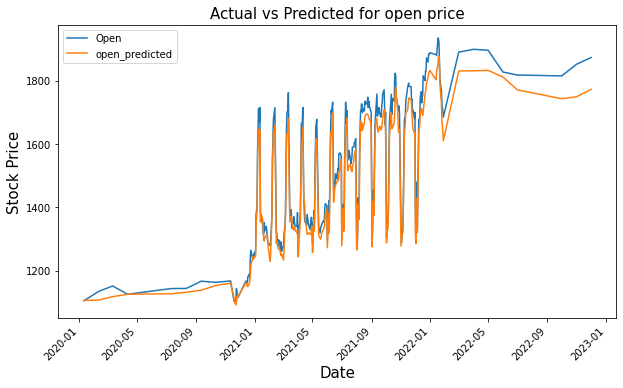

In [25]:
gs_slic_data[['Open','open_predicted']].plot(figsize=(10,6))
plt.xticks(rotation=45)
plt.xlabel('Date',size=15)
plt.ylabel('Stock Price',size=15)
plt.title('Actual vs Predicted for open price',size=15)
plt.show()

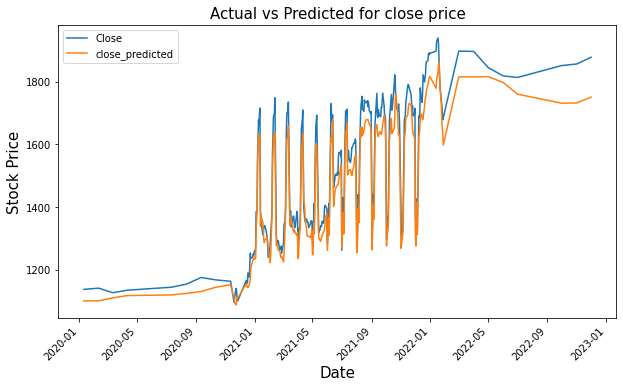

In [26]:
gs_slic_data[['Close','close_predicted']].plot(figsize=(10,6))
plt.xticks(rotation=45)
plt.xlabel('Date',size=15)
plt.ylabel('Stock Price',size=15)
plt.title('Actual vs Predicted for close price',size=15)
plt.show()

# Predicting upcoming 10 days

In [27]:
# Creating a dataframe and adding 10 days to existing index 

gs_slic_data = gs_slic_data.append(pd.DataFrame(columns=gs_slic_data.columns,index=pd.date_range(start=gs_slic_data.index[-1], periods=11, freq='D', closed='right')))


In [28]:
gs_slic_data['2022-01-23':'2022-01-28']

,Open,Close,open_predicted,close_predicted
2022-01-24,1770.0,1736.900024,1727.963623,1724.187866
2022-01-25,1725.0,1722.099976,1674.781738,1669.471924
2022-01-27,1704.0,1678.500000,1639.309204,1629.907104
2022-01-28,1685.0,1685.250000,1610.498169,1598.019775


In [29]:
upcoming_prediction = pd.DataFrame(columns=['Open','Close'],index=gs_slic_data.index)
upcoming_prediction.index=pd.to_datetime(upcoming_prediction.index)

In [30]:
curr_seq = test_seq[-1:]

for i in range(-10,0):
  up_pred = model.predict(curr_seq)
  upcoming_prediction.iloc[i] = up_pred
  curr_seq = np.append(curr_seq[0][1:],up_pred,axis=0)
  curr_seq = curr_seq.reshape(test_seq[-1:].shape)


In [31]:
upcoming_prediction[['Open','Close']] = MMS.inverse_transform(upcoming_prediction[['Open','Close']])

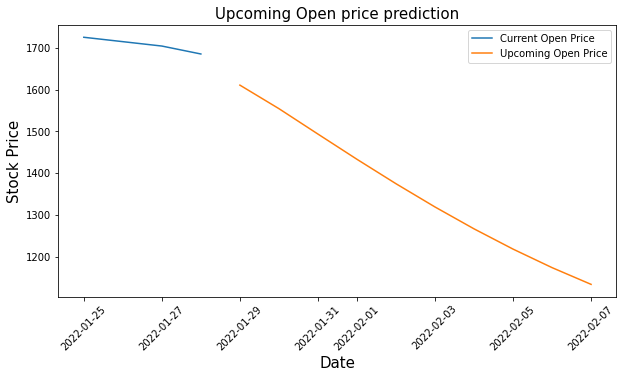

In [32]:
fg,ax=plt.subplots(figsize=(10,5))
ax.plot(gs_slic_data.loc['2022-01-25':,'Open'],label='Current Open Price')
ax.plot(upcoming_prediction.loc['2022-01-25':,'Open'],label='Upcoming Open Price')
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
ax.set_xlabel('Date',size=15)
ax.set_ylabel('Stock Price',size=15)
ax.set_title('Upcoming Open price prediction',size=15)
ax.legend()
fg.show()

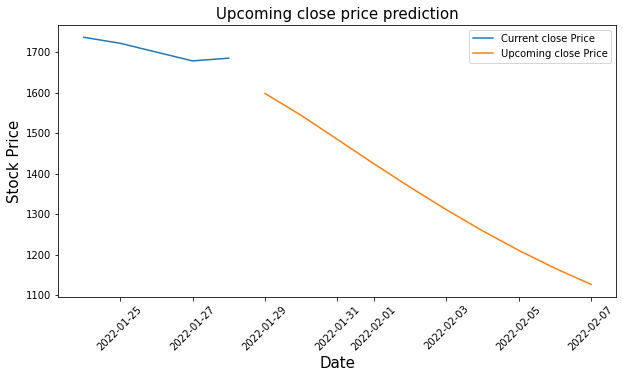

In [33]:
fg,ax=plt.subplots(figsize=(10,5))
ax.plot(gs_slic_data.loc['2022-01-24':,'Close'],label='Current close Price')
ax.plot(upcoming_prediction.loc['2022-01-24':,'Close'],label='Upcoming close Price')
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
ax.set_xlabel('Date',size=15)
ax.set_ylabel('Stock Price',size=15)
ax.set_title('Upcoming close price prediction',size=15)
ax.legend()
fg.show()